In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
#import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
%matplotlib inline


In [1]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9205196529567646104
xla_global_id: -1
]


In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

Num GPUs Available:  1


In [3]:
BASE_DIR = 'C:\\Users\\kacpe\\OneDrive\\Pulpit\\Uczelnia\\semestr5\\MachineLearning\\UTKFace\\UTKFace'
age_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

image_filenames[0]

'35_0_1_20170113142443251.jpg.chip.jpg'

In [4]:
for image in image_filenames:
    image_path = os.path.join(BASE_DIR, image)
    img_components = image.split('_')

    if img_components[0] == '.ipynb':
        continue
    age_label = int(img_components[0])
    
    # Append the image_path, age_label, and gender_label
    age_labels.append(age_label)
    image_paths.append(image_path)

In [5]:
print(f'Number of age_labels: {len(age_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of image_paths: 23708


In [6]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'] = image_paths, age_labels
df.head(5)

,image_path,age
0,C:\Users\kacpe\OneDrive\Pulpit\Uczelnia\semest...,35
1,C:\Users\kacpe\OneDrive\Pulpit\Uczelnia\semest...,53
2,C:\Users\kacpe\OneDrive\Pulpit\Uczelnia\semest...,2
3,C:\Users\kacpe\OneDrive\Pulpit\Uczelnia\semest...,35
4,C:\Users\kacpe\OneDrive\Pulpit\Uczelnia\semest...,26


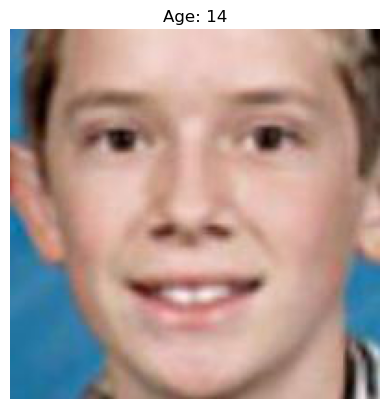

In [7]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age}')
plt.axis('off')
plt.imshow(IMG)

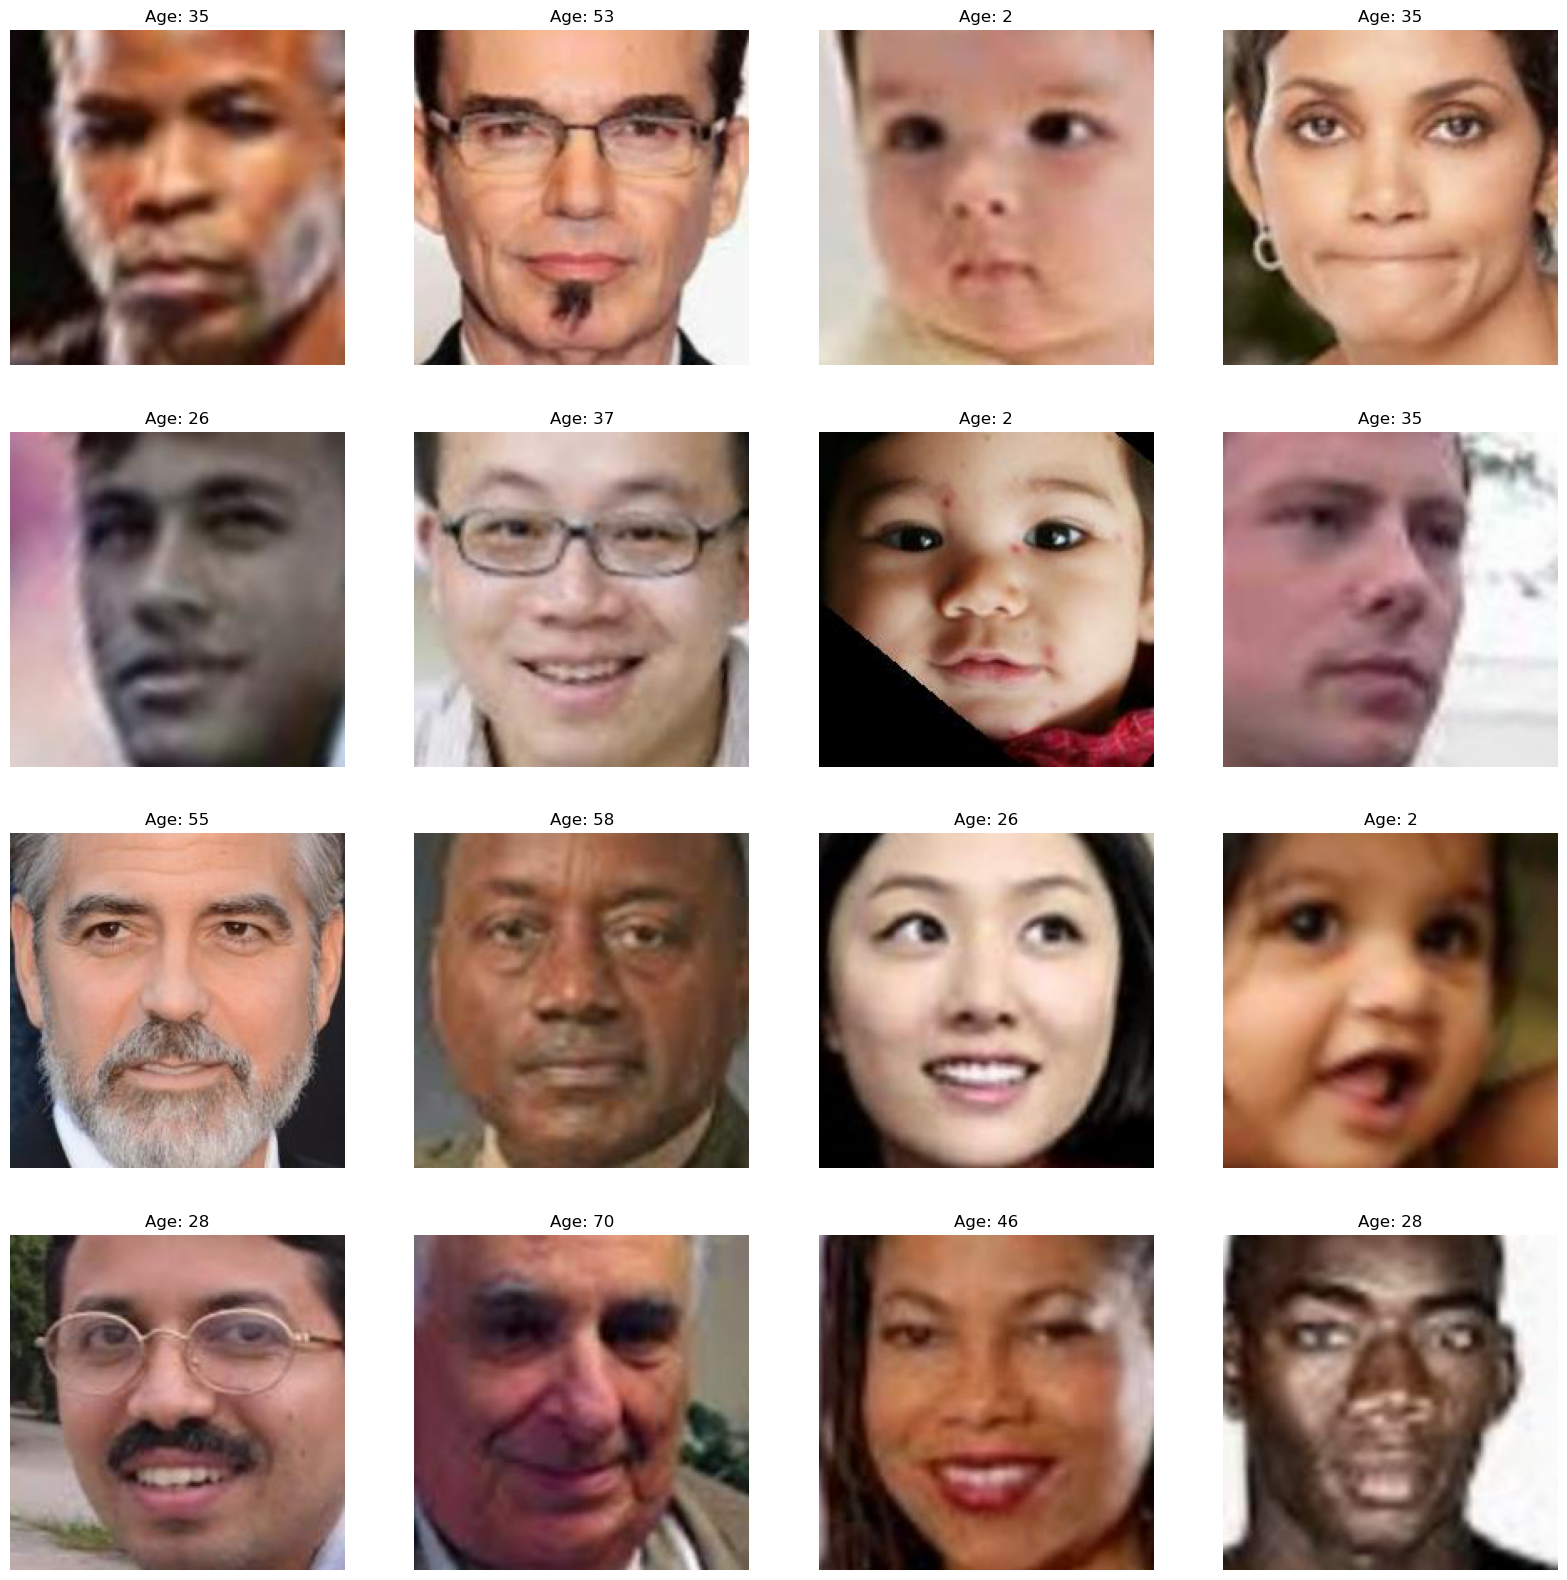

In [8]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age}')
    plt.imshow(img)

In [9]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image)
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [10]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [11]:
X.shape

(23708, 128, 128, 3)

In [12]:
X = X / 255.0

In [13]:
y_age = np.array(df['age'])

In [14]:
import keras

In [15]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [16]:
input_shape = (128, 128, 3)

In [17]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=input_shape, padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters=filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(1, activation="relu"))

In [18]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [20]:
history = model.fit(x=X, y=y_age,
                    batch_size=1, epochs=10, validation_split=0.2)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [24]:
from tensorflow.keras.models import load_model
model.save('ResNet_reg.keras')

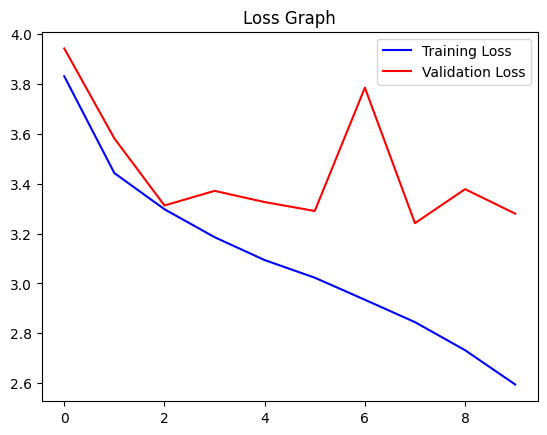

In [19]:
# plot results for age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [20]:
def get_image_features(image):
  img = load_img(image)
  img = img.resize((128, 128), Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 3)
  img = img / 255.0
  return img

In [21]:
img_to_test = 'FaceRecognition/CamData/data/test/images/00bf6f4c-7fdd-11ee-9103-ec773ba9cb5a.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)

pred[0].round(2)

1/1 [==============================] - 1s 507ms/step


array([0.  , 0.11, 0.03, 0.07, 0.05, 0.01, 0.01, 0.01, 0.  , 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.01,
       0.  , 0.01, 0.01, 0.01, 0.02, 0.  , 0.  , 0.  , 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.02, 0.01, 0.  , 0.  , 0.  ,
       0.  , 0.01, 0.01, 0.  , 0.01, 0.  , 0.01, 0.  , 0.  , 0.02, 0.02,
       0.  , 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.01, 0.  , 0.04,
       0.01, 0.01, 0.02, 0.  , 0.03, 0.01, 0.  , 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.04, 0.03, 0.  , 0.  , 0.01, 0.01, 0.01, 0.03, 0.  ,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

In [22]:
def get_result(model, image):
    features = get_image_features(img_to_test)
    pred = model.predict(features)
    max = pred[0][0]
    result = 0
    i = 0
    for p in pred[0]:
        if p > max:
            max = p
            result = i
        i = i+1
    return result

1/1 [==============================] - 0s 41ms/step


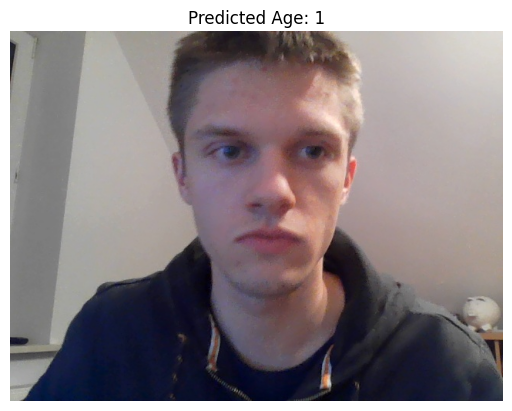

In [23]:
age = get_result(model, img_to_test)

plt.title(f'Predicted Age: {age}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))